# Installation des bibliothèques

In [2]:
print("Installation des bibliothèques")

# Installer les bibliothèques pour le machine learning et DistilBERT
%pip install -r ../requirements.txt

# Vérifier que tout est bien installé
print("Installation terminée !")

Installation des bibliothèques
Note: you may need to restart the kernel to use updated packages.
Installation terminée !


# Importation des bibliothèques

In [3]:
import pandas as pd  # Pour manipuler les données
import numpy as np   # Pour les calculs
import torch        # La base pour faire du deep learning et du machine learning
import matplotlib.pyplot as plt  # Pour faire des graphiques
import seaborn as sns           # Pour faire des graphiques


# Bibliothèques pour DistilBERT
from transformers import (
    DistilBertTokenizer,    # Pour convertir le texte en nombres
    DistilBertForSequenceClassification,  # Le modèle DistilBERT pour classifier les séquences
    TrainingArguments,      # Les paramètres d'entraînement
    Trainer                 # Pour entraîner le modèle facilement
)


# Bibliothèques pour préparer les données
from sklearn.model_selection import train_test_split  # Pour diviser les données en train et test
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # Pour évaluer le modèle
from torch.utils.data import Dataset  # Pour créer un dataset personnalisé

print("Toutes les bibliothèques sont importées !")

Toutes les bibliothèques sont importées !


# Chargement et exploration des données

Données chargées ! Il y'a 18650 emails au total
Colonnes disponibles : ['Unnamed: 0', 'Email Text', 'Email Type']

Aperçu des données :
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  

Répartition des types d'emails :
Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64


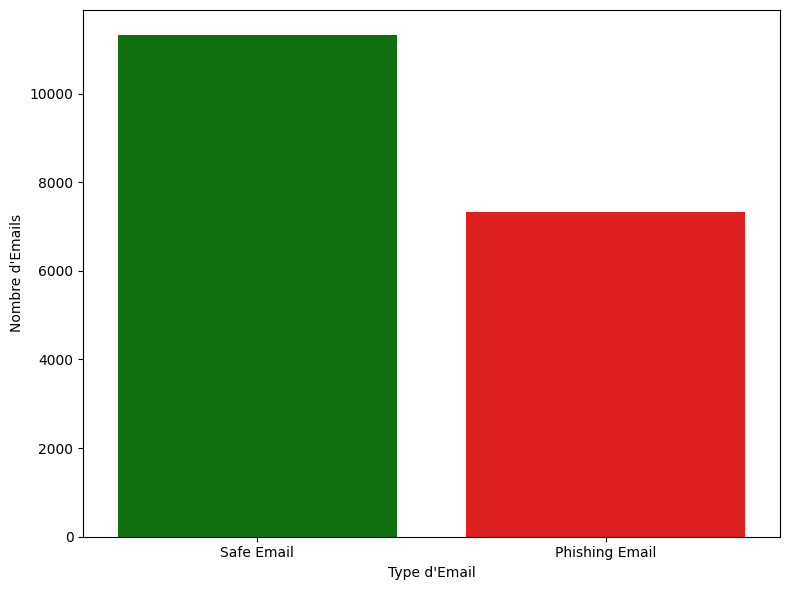

In [5]:
# Charger le fichier CSV
df = pd.read_csv('~/Documents/phishing-email-detector/data/Phishing_Email.csv')
print(f"Données chargées ! Il y'a {len(df)} emails au total")
print(f"Colonnes disponibles : {list(df.columns)}")

# Regarder les premières lignes
print("\nAperçu des données :")
print(df.head())

# Vérifier la répartition des classes
print("\nRépartition des types d'emails :")
class_counts = df['Email Type'].value_counts()
print(class_counts)
unique_class_count = class_counts.index.tolist()

# Define a custom color map 
color_map = {
    'Phishing Email': 'red',
    'Safe Email': 'green',}


# Créer un graphique pour visualiser la répartition
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Email Type', hue='Email Type', palette=color_map, legend=False) 
plt.xlabel('Type d\'Email')
plt.ylabel('Nombre d\'Emails')
plt.tight_layout()
plt.show()

# Préparation des données

In [31]:
# Nettoyer les données (supprimer les valeurs manquantes)
a = df.isnull().sum().sum()
df = df.dropna()
print(f"cellules vides supprimées : {a - df.isnull().sum().sum()}")

# Convertir les labels en nombres
# Safe Email = 0, Phishing Email = 1
label_mapping = {'Safe Email': 0, 'Phishing Email': 1}
df['label'] = df['Email Type'].map(label_mapping)

print("Conversion des labels :")
print("Safe Email → 0")
print("Phishing Email → 1")

# Vérifier la conversion
print(f"\nRépartition après conversion :")
print(df['label'].value_counts())

# Préparer les textes et les labels
texts = df['Email Text'].tolist()
labels = df['label'].tolist()

print(f"{len(texts)} emails prêts pour l'entraînement !")


cellules vides supprimées : 0
Conversion des labels :
Safe Email → 0
Phishing Email → 1

Répartition après conversion :
label
0    11322
1     7312
Name: count, dtype: int64
18634 emails prêts pour l'entraînement !


# Division des données

- Train (70%) : Pour entrainer le modèle
- Validation (15%) : Pour ajuster les paramètres pendant l'entraînement
- Test (15%) : Pour évaluer les performances finales (données jamais vues)

In [8]:
# Première division : 85% train+val, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    texts, labels, test_size=0.15, random_state=42, stratify=labels
)

# Deuxième division : 70% train, 15% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
)  # 0.176 * 0.85 ≈ 0.15

print(f"Répartition des données :")
print(f"Entraînement : {len(X_train)} emails ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Validation : {len(X_val)} emails ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test : {len(X_test)} emails ({len(X_test)/len(texts)*100:.1f}%)")


Répartition des données :
Entraînement : 13050 emails (70.0%)
Validation : 2788 emails (15.0%)
Test : 2796 emails (15.0%)


# Préparation de DistilBERT

- Version "légère" de BERT (plus rapide, moins de mémoire)
- Pré-entraîné sur énormément de textes
- Comprend déjà bien le langage, on va juste l'adapter à notre tâche

In [9]:
# Charger le tokenizer (convertit le texte en nombres)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
print("Tokenizer chargé !")

# Charger le modèle pré-entraîné
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # 2 classes : Safe (0) et Phishing (1)
)
print("Modèle DistilBERT chargé !")

# Fonction pour encoder les textes
def encode_texts(texts, tokenizer, max_length=512):
    """
    Cette fonction convertit le texte en format que DistilBERT comprend

    Args:
        texts: Liste des textes à encoder
        tokenizer: Le tokenizer DistilBERT
        max_length: Longueur maximum du texte (512 tokens max pour DistilBERT)
    
    Returns:
        Dictionnaire avec les encodages
    """
    return tokenizer(
        texts,
        truncation=True,        # Couper si trop long
        padding=True,           # Ajouter des 0 si trop court
        max_length=max_length,  # Longueur maximum des séquences
        return_tensors='pt'     # Retourner des tenseurs PyTorch
    )

Tokenizer chargé !


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modèle DistilBERT chargé !


# Création du Dataset

In [11]:
class EmailDataset(Dataset):
    """
    Classe pour organiser nos données de manière que DistilBERT comprenne
    """
    
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Encoder le texte
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Créer les datasets
train_dataset = EmailDataset(X_train, y_train, tokenizer)
val_dataset = EmailDataset(X_val, y_val, tokenizer)
test_dataset = EmailDataset(X_test, y_test, tokenizer)

print(f"Datasets créés !")
print(f"Dataset d'entraînement : {len(train_dataset)} mails")
print(f"Dataset de validation : {len(val_dataset)} mails")
print(f"Dataset de test : {len(test_dataset)} mails")

Datasets créés !
Dataset d'entraînement : 13050 mails
Dataset de validation : 2788 mails
Dataset de test : 2796 mails


# Configuration de l'entraînement

In [12]:
training_args = TrainingArguments(
    output_dir='./results',          # Dossier de sauvegarde
    num_train_epochs=3,              # 3 époques (tours complets des données)
    per_device_train_batch_size=16,  # 16 emails par batch
    per_device_eval_batch_size=64,   # 64 emails pour l'évaluation
    warmup_steps=500,                # 500 étapes d'échauffement
    weight_decay=0.01,               # Régularisation (évite le surajustement)
    logging_dir='./logs',            # Dossier des logs
    logging_steps=50,                # Log toutes les 50 étapes
    eval_strategy="epoch",      # Évaluer à chaque époque
    save_strategy="epoch",           # Sauvegarder à chaque époque
    load_best_model_at_end=True,     # Charger le meilleur modèle à la fin
    metric_for_best_model="eval_loss", # Métrique pour choisir le meilleur
    learning_rate=2e-5,              # Vitesse d'apprentissage (2e-5 = standard pour BERT)
)

print("Configuration terminée !")


Configuration terminée !


# Fonction d'évaluation

In [13]:
def compute_metrics(eval_pred):
    """
    Fonction pour calculer les métriques de performance
    
    Args:
        eval_pred: Prédictions et vraies étiquettes
    
    Returns:
        Dictionnaire avec les métriques
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'accuracy': accuracy,
    }

# Création du Trainer

In [14]:
trainer = Trainer(
    model=model,                         # Notre modèle DistilBERT
    args=training_args,                  # Les paramètres d'entraînement
    train_dataset=train_dataset,         # Données d'entraînement
    eval_dataset=val_dataset,            # Données de validation
    compute_metrics=compute_metrics,     # Fonction de calcul des métriques
)

print("Trainer créé !")

Trainer créé !


# Entraînement du modèle

Cette section lance l'entraînement du modèle. Cela peut prendre 10-30 minutes selon vos données.

In [20]:
print("Entrainement du modèle")

# Lancer l'entraînement
trainer.train()

print("\nEntrainement terminé !")

Entrainement du modèle


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.086600,0.089240,0.004200,0.964849
2,0.055700,0.109493,0.004200,0.963056
3,0.013900,0.087758,0.004200,0.968436



Entrainement terminé !


# Évaluation du modèle

Précision sur les données de test : 0.9753 (97.53%)

Rapport de classification détaillé :
                precision    recall  f1-score   support

    Safe Email       0.99      0.97      0.98      1699
Phishing Email       0.96      0.98      0.97      1097

      accuracy                           0.98      2796
     macro avg       0.97      0.98      0.97      2796
  weighted avg       0.98      0.98      0.98      2796


Matrice de confusion :


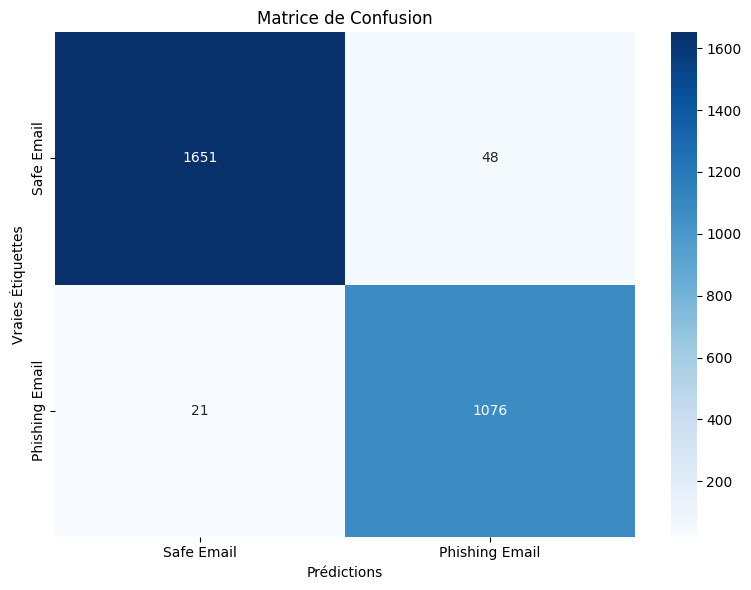

In [21]:
# Faire des prédictions sur le set de test
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# Calculer les métriques
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision sur les données de test : {accuracy:.4f} ({accuracy*100:.2f}%)")

# Rapport de classification détaillé
print("\nRapport de classification détaillé :")
target_names = ['Safe Email', 'Phishing Email']
print(classification_report(y_test, y_pred, target_names=target_names))

# Matrice de confusion
print("\nMatrice de confusion :")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies Étiquettes')
plt.tight_layout()
plt.show()

# Sauvegarde du modèle

In [ ]:
# Sauvegarder le modèle et le tokenizer
model_save_path = "./phishing-detector-model"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Modèle sauvegardé dans : {model_save_path}")

✅ Modèle sauvegardé dans : ./phishing-detector-model
💡 Vous pouvez maintenant télécharger ce dossier et l'utiliser ailleurs !


# Test du modèle sur des exemples

In [30]:
import torch

def predict_email(text, model, tokenizer, phishing_threshold=0.97, uncertain_threshold=0.90):
    """
    Fonction pour prédire si un email est du phishing ou non, avec une gestion de l'incertitude.
    
    Args:
        text: Le texte de l'email à analyser
        model: Le modèle entraîné
        tokenizer: Le tokenizer
        phishing_threshold: Seuil à partir duquel on considère l'email comme phishing
        uncertain_threshold: Zone tampon où l'email est jugé incertain (à vérifier manuellement)
    
    Returns:
        Tuple (résultat, confiance)
    """
    # Déterminer le device (CPU ou GPU)
    device = next(model.parameters()).device

    # Encoder le texte
    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512
    )

    # Déplacer les inputs sur le bon device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prédiction
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        probs = predictions[0]
        phishing_prob = probs[1].item()
        safe_prob = probs[0].item()

        # Classification avec gestion de l'incertitude
        if phishing_prob >= phishing_threshold:
            result = "Phishing Email"
            confidence = phishing_prob
        elif phishing_prob >= uncertain_threshold:
            result = "Alerte modérée (à vérifier)"
            confidence = phishing_prob
        else:
            result = "Safe Email"
            confidence = safe_prob

    return result, confidence


# ====================
# Emails de test
# ====================

test_emails = [
    """Dear Netflix Member,

We're updating our subscription prices to continue bringing you the best entertainment experience. Starting with your next billing date, your Premium plan will increase from $19.99 to $22.99 per month.

As a valued member since 2021, you'll continue to enjoy:
- Ultra HD streaming
- Watch on 4 devices at once
- Ad-free viewing
- Downloads on up to 4 devices

If you wish to review your options or make changes to your subscription, please visit netflix.com/account.

Thank you for being a Netflix member.

Best regards,
The Netflix Team""",

    """URGENT SECURITY ALERT!!!

We detected suspicious login attempts on your PayPal account from an unknown device in Bangkok, Thailand. If this wasn't you, your account may be compromised!

To secure your account immediately:
1. Click here: [secure-paypal-verify.com]
2. Verify your identity
3. Update your security settings

WARNING: Your account will be suspended in 24 hours if you don't take action!

PayPal Security Team""",

    """Hello Sarah,

I've reviewed the Q2 marketing report you sent and everything looks great! The social media campaign results are particularly impressive.

Could you prepare a brief presentation for next Tuesday's team meeting? We'd like to share these insights with the broader marketing team.

Also, don't forget we have our weekly catch-up tomorrow at 2 PM EST.

Best regards,
Mike Johnson
Marketing Director""",

    """🎉 Special Weekend Sale! 🎉

Get 80% OFF on ALL Apple Products!
- iPhone 15 Pro: Only $299
- MacBook Pro: Starting at $499
- AirPods Pro: Just $49

LIMITED TIME OFFER - First 100 customers only!
🔥 Click here to claim your discount: [www.apple-mega-deals.shop]

This offer cannot be combined with other discounts. Don't miss out!

Sent from: Apple Store Deals""",
"""Subject: Meeting Follow-up and Next Steps

Hi team,

Thank you all for your contributions during today's strategy meeting. I’ve attached the minutes for your review. Please make sure to go through them and share your feedback by Thursday.

Action items:
- Marketing: Finalize the Q3 campaign proposal by next Monday.
- Tech: Complete the platform performance audit by end of the week.
- HR: Prepare onboarding materials for the new hires starting July 1st.

Let me know if you have any questions.

Best,
Laura Smith
Chief Operations Officer
Innovatek Solutions""",
"""Subject: Reminder: Password Change Required by End of Month

Dear Employee,

As part of our ongoing commitment to security, please update your company account password before July 31st to comply with our IT policy.

To update your password, please visit the official internal portal here: https://intranet.company.com/password-reset

If you have already updated your password recently, no further action is needed.

For assistance, contact IT support at it-support@company.com.

Thank you for your cooperation.

Best regards,  
IT Security Team

""",
"""Subject: Monthly Invoice from Your Utility Provider

Hello,

Please find attached your invoice for this month’s electricity usage. Kindly review the details and make the payment by the due date to avoid any service interruption.

You can view and pay your bill securely here: http://utility-payments.example.com/invoice123

If you have any questions, please contact customer.service@utility-company.com.

Thank you for your prompt attention.

Best regards,  
Utility Billing Department
"""
]

# ====================
# Exécution des tests
# ====================

print("Test sur quelques exemples :")
for i, email in enumerate(test_emails, 1):
    prediction, confidence = predict_email(email, model, tokenizer)
    print(f"\nEmail {i}:")
    print(f"Texte: {email[:80]}...")
    print(f"Prédiction: {prediction}")
    print(f"Confiance: {confidence:.4f} ({confidence*100:.2f}%)")


Test sur quelques exemples :

Email 1:
Texte: Dear Netflix Member,

We're updating our subscription prices to continue bringin...
Prédiction: Phishing Email
Confiance: 0.9902 (99.02%)

Email 2:
Texte: URGENT SECURITY ALERT!!!

We detected suspicious login attempts on your PayPal a...
Prédiction: Phishing Email
Confiance: 0.9995 (99.95%)

Email 3:
Texte: Hello Sarah,

I've reviewed the Q2 marketing report you sent and everything look...
Prédiction: Safe Email
Confiance: 0.9997 (99.97%)

Email 4:
Texte: 🎉 Special Weekend Sale! 🎉

Get 80% OFF on ALL Apple Products!
- iPhone 15 Pro: O...
Prédiction: Phishing Email
Confiance: 0.9997 (99.97%)

Email 5:
Texte: Subject: Meeting Follow-up and Next Steps

Hi team,

Thank you all for your cont...
Prédiction: Safe Email
Confiance: 0.9998 (99.98%)

Email 6:
Texte: Subject: Reminder: Password Change Required by End of Month

Dear Employee,

As ...
Prédiction: Safe Email
Confiance: 0.9988 (99.88%)

Email 7:
Texte: Subject: Monthly Invoice from Your U